In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gensim.downloader as api
# glove_model = api.load('glove-wiki-gigaword-300')

In [ ]:
# glove_model["beautiful"]

In [ ]:
# !wget http://mattmahoney.net/dc/text8.zip

Hallo leute! Today’s post we will implement the awesome model to learn word embeddings Glove: Global Vectors for Word Representation, using Pytorch. Developed by Stanford, the main idea is to leverage the matrix of word cooccurrences in order to extract “dimensions of meaning”, outputing word vectors that naturally captures word semantics and thus being useful representations in a lot of tasks, such word analogies. You can find more information in the original paper here .

For this project, we will use the text8 dataset (that can be download here). This dataset is a dump of cleaned wikipedia texts. More details here .

First, we just import the necessary libs.

In [ ]:
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE

Next we will create a dataset class to manage our feature extraction and batch generation. We must create a cooccurence matrix for every word to feed the glove model. We will generate a vocab of ~190k words. If we create a common matrix, it would have 190000² entries, which would result in ~36 billion entries. If we consider each value a 32bit integer, we are talking of ~135GB of memory, too much to store and process. To handle this issue we can leverage the fact that most of the entries of this matrix are 0 so we just need to store the non-zero values, which drastically reduce the amount of memory necessary.

In [ ]:
class GloveDataset:

  def __init__(self, text, n_words=200000, window_size=5):
      self._window_size = window_size
      self._tokens = text.split(" ")[:n_words]
      word_counter = Counter()
      word_counter.update(self._tokens)
      self._word2id = {w:i for i, (w,_) in enumerate(word_counter.most_common())}
      self._id2word = {i:w for w, i in self._word2id.items()}
      self._vocab_len = len(self._word2id)

      self._id_tokens = [self._word2id[w] for w in self._tokens]

      self._create_coocurrence_matrix()

      print("# of words: {}".format(len(self._tokens)))
      print("Vocabulary length: {}".format(self._vocab_len))

  def _create_coocurrence_matrix(self):
      cooc_mat = defaultdict(Counter)
      for i, w in enumerate(self._id_tokens):
          start_i = max(i - self._window_size, 0)
          end_i = min(i + self._window_size + 1, len(self._id_tokens))
          for j in range(start_i, end_i):
              if i != j:
                  c = self._id_tokens[j]
                  cooc_mat[w][c] += 1 / abs(j-i)

      self._i_idx = list()
      self._j_idx = list()
      self._xij = list()

      #Create indexes and x values tensors
      for w, cnt in cooc_mat.items():
          for c, v in cnt.items():
              self._i_idx.append(w)
              self._j_idx.append(c)
              self._xij.append(v)

      self._i_idx = torch.LongTensor(self._i_idx).cuda()
      self._j_idx = torch.LongTensor(self._j_idx).cuda()
      self._xij = torch.FloatTensor(self._xij).cuda()


  def get_batches(self, batch_size):
      #Generate random idx
      rand_ids = torch.LongTensor(np.random.choice(len(self._xij), len(self._xij), replace=False))

      for p in range(0, len(rand_ids), batch_size):
          batch_ids = rand_ids[p:p+batch_size]
          yield self._xij[batch_ids], self._i_idx[batch_ids], self._j_idx[batch_ids]
# !unzip text8.zip
dataset = GloveDataset(open("/content/drive/MyDrive/ENDProgram/Session14/EmbeddingFile/embedding_file.txt").read(), 10000000)

# of words: 1866685
Vocabulary length: 17599


Here we create the class of our glove model. In its forward pass it will perform the yellow part of the Glove loss function, described in the original paper:

![](https://cdn.hashnode.com/res/hashnode/image/upload/v1587152473299/6HedPZypj.png?auto=compress)


In [ ]:
EMBED_DIM = 256
class GloveModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(GloveModel, self).__init__()
        self.wi = nn.Embedding(num_embeddings, embedding_dim)
        self.wj = nn.Embedding(num_embeddings, embedding_dim)
        self.bi = nn.Embedding(num_embeddings, 1)
        self.bj = nn.Embedding(num_embeddings, 1)

        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()

    def forward(self, i_indices, j_indices):
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()

        x = torch.sum(w_i * w_j, dim=1) + b_i + b_j

        return x
glove = GloveModel(dataset._vocab_len, EMBED_DIM)
glove.cuda()


GloveModel(
  (wi): Embedding(17599, 256)
  (wj): Embedding(17599, 256)
  (bi): Embedding(17599, 1)
  (bj): Embedding(17599, 1)
)

We must define a function to compute the weighting term f(Xij) of the loss function as per described in the paper:


![](https://cdn.hashnode.com/res/hashnode/image/upload/v1587152743199/bjCyXW0Wc.png?auto=compress)


In [ ]:
def weight_func(x, x_max, alpha):
    wx = (x/x_max)**alpha
    wx = torch.min(wx, torch.ones_like(wx))
    return wx.cuda()


The loss function described in the Glove paper is a weighted mean squared error. Pytorch 1.0 doesn’t have implementation for it, so we must write it ourselves. A good practice is to reuse any piece of this function already implemented so we take advantage of any optimization it might have:

In [ ]:
def wmse_loss(weights, inputs, targets):
    loss = weights * F.mse_loss(inputs, targets, reduction='none')
    return torch.mean(loss).cuda()


Although we are using a diferent configuration (like the dataset) of the original paper, we will use the same optimizer and learning rate it describes.

In [ ]:
optimizer = optim.Adagrad(glove.parameters(), lr=0.05)


Now we can write our training loop. The ALPHA and X_MAX parameters are set accoring to the paper. We also save our model states every 100 epochs.

In [ ]:
cd /content/drive/MyDrive/ENDProgram/Session14/Embedding_Model

/content/drive/MyDrive/ENDProgram/Session14/Embedding_Model


In [ ]:
N_EPOCHS = 100
BATCH_SIZE = 2048
X_MAX = 100
ALPHA = 0.75
n_batches = int(len(dataset._xij) / BATCH_SIZE)
loss_values = list()
for e in range(1, N_EPOCHS+1):
    batch_i = 0

    for x_ij, i_idx, j_idx in dataset.get_batches(BATCH_SIZE):

        batch_i += 1

        optimizer.zero_grad()

        outputs = glove(i_idx, j_idx)
        weights_x = weight_func(x_ij, X_MAX, ALPHA)
        loss = wmse_loss(weights_x, outputs, torch.log(x_ij))

        loss.backward()

        optimizer.step()

        loss_values.append(loss.item())

        if batch_i % 100 == 0:
            print("Epoch: {}/{} \t Batch: {}/{} \t Loss: {}".format(e, N_EPOCHS, batch_i, n_batches, np.mean(loss_values[-20:])))  

    print("Saving model...")
    torch.save(glove.state_dict(), "Session14_Embedding_100.pt")

    #checkpoint = {'model': GloveModel(dataset._vocab_len, EMBED_DIM),
    #      'state_dict': glove.state_dict()}
    
    #torch.save(checkpoint, 'checkpoint.pth')
    


Epoch: 1/100 	 Batch: 100/303 	 Loss: 1.7946775019168855
Epoch: 1/100 	 Batch: 200/303 	 Loss: 1.5369214832782745
Epoch: 1/100 	 Batch: 300/303 	 Loss: 1.2935827493667602
Saving model...
Epoch: 2/100 	 Batch: 100/303 	 Loss: 0.5334748461842537
Epoch: 2/100 	 Batch: 200/303 	 Loss: 0.5067763581871987
Epoch: 2/100 	 Batch: 300/303 	 Loss: 0.4861528143286705
Saving model...
Epoch: 3/100 	 Batch: 100/303 	 Loss: 0.33627319484949114
Epoch: 3/100 	 Batch: 200/303 	 Loss: 0.32138820439577104
Epoch: 3/100 	 Batch: 300/303 	 Loss: 0.323635071516037
Saving model...
Epoch: 4/100 	 Batch: 100/303 	 Loss: 0.24242447465658187
Epoch: 4/100 	 Batch: 200/303 	 Loss: 0.23652661591768265
Epoch: 4/100 	 Batch: 300/303 	 Loss: 0.2427513338625431
Saving model...
Epoch: 5/100 	 Batch: 100/303 	 Loss: 0.1973481848835945
Epoch: 5/100 	 Batch: 200/303 	 Loss: 0.18893284499645233
Epoch: 5/100 	 Batch: 300/303 	 Loss: 0.19178911969065665
Saving model...
Epoch: 6/100 	 Batch: 100/303 	 Loss: 0.16417578607797623
Ep

In [ ]:
!pwd

/content/drive/My Drive/ENDProgram/Session14/Embedding_Model


In [ ]:
dataset._id2word[1000]

'depth'

In [ ]:
emb_i = glove.wi.weight.cpu().data.numpy()
emb_j = glove.wj.weight.cpu().data.numpy()
emb = np.add(emb_i,emb_j)

In [ ]:
len(dataset._id2word)

17599

In [ ]:
emb.shape

(17599, 256)

In [ ]:
emb[2]

array([-2.7840906e-01,  1.1586275e+00,  3.6380088e-01, -2.4129719e-02,
       -8.2206869e-01, -3.6133245e-01, -3.1689304e-01, -7.1929276e-02,
        8.2628809e-02, -4.3578264e-01,  1.2710667e-01,  8.3547020e-01,
       -4.2809010e-02, -1.0710127e+00, -1.0164690e-01,  5.1881075e-03,
       -2.6639052e-02,  4.3136126e-01, -3.1934708e-02,  4.9636817e-01,
       -2.1117288e-01,  6.7260742e-01,  9.9414155e-02,  1.1164223e-02,
       -7.2322500e-01,  2.1870229e-01,  4.1612333e-01,  6.7049362e-02,
        7.5142086e-04,  1.2083288e-01, -3.4314260e-01, -2.9849026e-01,
       -9.0127319e-01,  7.1684551e-01, -1.3437860e-01,  4.7781590e-01,
       -1.3991559e-01, -6.2089300e-01, -3.8127646e-01, -1.0011928e+00,
       -5.2145422e-01, -1.1609532e-01, -6.6471690e-01,  5.3360206e-01,
       -9.7043985e-01, -8.0274034e-01,  7.4322343e-01, -1.0835588e+00,
        7.0034873e-01,  5.2684277e-02, -6.5017104e-02,  2.6893944e-02,
       -5.7170361e-02, -2.0860894e-01,  5.5884582e-01,  4.2519772e-01,
      

In [ ]:
#emb[]
with open('custom_embeddings.txt', 'w+') as f:
    for idx in range(len(dataset._id2word)):
        vector_str = ' '.join([str(v) for v in emb[idx]])
        word = dataset._id2word[idx]
        #print(f'{word} {vector_str}\n')
        f.write(f'{word} {vector_str}\n')

        

In [ ]:
with open('custom_embeddings.txt', 'w+') as f:
    for token, vector in cust_embedding.items():
        vector_str = ' '.join([str(v) for v in vector])
        f.write(f'{token} {vector_str}\n')

In [ ]:
emb[1,]

In [ ]:
import spacy
nlp = spacy.load(PyGlovemodel)
#glove_model = api.load('PyGlovemodel')

In [ ]:
glove_file = datapath('test_glove.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

In [ ]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

In [ ]:
model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
model.wv.save_word2vec_format("/content/drive/MyDrive/ENDProgram/Session14/EmbeddingFile/Session14_Embedding.pt")

In [ ]:
!gzip /content/drive/MyDrive/ENDProgram/Session14/EmbeddingFile/Session14_Embedding.pt

In [ ]:
!python -m spacy init-model en '/content/drive/MyDrive/ENDProgram/Session14/Embedding_Model/word2vec_py.model' --vectors-loc '/content/drive/MyDrive/ENDProgram/Session14/EmbeddingFile/Session14_Embedding.pt.gz'

In [ ]:
plt.plot(loss_values)

Here we sum over the two embedding matrices (as per recommendation of the original paper) to improve results. We then plot the TSNE space of the top 300 words to validate our word embeddings.

In [ ]:
emb_i = glove.wi.weight.cpu().data.numpy()
emb_j = glove.wj.weight.cpu().data.numpy()
npaddemb = np.add(emb_i, emb_j)

In [ ]:
npaddemb[:2]

(17599, 300)


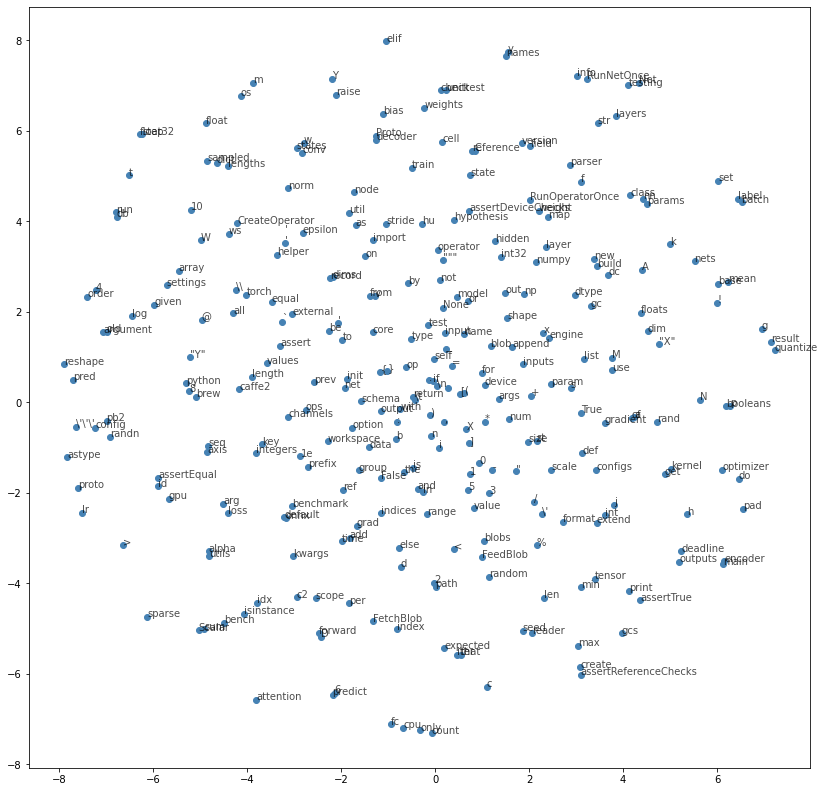

In [ ]:
emb_i = glove.wi.weight.cpu().data.numpy()
emb_j = glove.wj.weight.cpu().data.numpy()
emb = np.add(emb_i, emb_j)
print(emb.shape)
top_k = 300
tsne = TSNE(metric='cosine', random_state=123)
embed_tsne = tsne.fit_transform(emb[:top_k, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(top_k):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(dataset._id2word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)


Checking the words that are close, we can say that our model performs pretty good! We can check that it clusters the direction words north, south, west, east and even central. It also clusters together words with their plural form like system/systems and language/languages.